This problem is taken from this [https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection/](https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection/). 

>The task is to predict the age of a person from his or her facial attributes. For simplicity, the problem has been converted to a multi-class problem with classes as Young, Middle and Old.

I attempted this problem almost 1.5 years ago with knowledge of Convolutions only. 

Today, I am at least in a position to apply Deep Neural Networks to problems like these. Thanks to the community and great learning resources. The code that is presented here have been taken from many places. I think being a programmer it is equally important to be able to read people's code and reuse it. (Opinions are mine)

I would like to thank the following people specifically - 
- Adrian Rosebrock, for putting together a tutorial on [Deep Learning and Medical Image Analysis with Keras](https://www.pyimagesearch.com/2018/12/03/deep-learning-and-medical-image-analysis-with-keras/) which is one of the classiest tutorials I have ever read. 
- FAIZAN SHAIKH, for the blog [Hands on with Deep Learning – Solution for Age Detection Practice Problem](https://www.analyticsvidhya.com/blog/2017/06/hands-on-with-deep-learning-solution-for-age-detection-practice-problem/) which tremendously served me as a reference. 

In [2]:
# Dependencies

import os
import random
import numpy as np 

import pandas as pd
from scipy.misc import imread
from subprocess import check_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
# I used Adrian's custom ResNet model. For importing modules from custom scripts in Kaggle
# Kernels, you need to do some hacks. The following ensures the initial directory 
# structure is retained if anything went wrong in order to load up the custom script. 
os.chdir("/kaggle/working/")

In [4]:
train_csv = pd.read_csv('../input/traincsv/train.csv')
test_csv = pd.read_csv('../input/testcsv/test.csv')

In [ ]:
# train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [5]:
print(check_output(["ls", "../input/traintestzip/train/Train"]).decode("UTF-8"))

0.jpg
1.jpg
100.jpg
10000.jpg
10001.jpg
10004.jpg
10007.jpg
10008.jpg
10009.jpg
10011.jpg
10013.jpg
10015.jpg
10016.jpg
10017.jpg
10018.jpg
10019.jpg
1002.jpg
10021.jpg
10023.jpg
10025.jpg
10026.jpg
10027.jpg
10028.jpg
1003.jpg
10030.jpg
10031.jpg
10034.jpg
10035.jpg
10036.jpg
10038.jpg
1004.jpg
10040.jpg
10041.jpg
10043.jpg
10045.jpg
10046.jpg
10047.jpg
10048.jpg
1005.jpg
10050.jpg
10051.jpg
10053.jpg
10055.jpg
10056.jpg
10057.jpg
10058.jpg
10059.jpg
1006.jpg
10061.jpg
10062.jpg
10063.jpg
10065.jpg
10067.jpg
10068.jpg
10069.jpg
1007.jpg
10070.jpg
10071.jpg
10073.jpg
10076.jpg
10078.jpg
10079.jpg
1008.jpg
10080.jpg
10081.jpg
10082.jpg
10084.jpg
10085.jpg
10086.jpg
10087.jpg
10088.jpg
1009.jpg
10091.jpg
10092.jpg
10093.jpg
10095.jpg
10096.jpg
10097.jpg
10098.jpg
10099.jpg
101.jpg
1010.jpg
10100.jpg
10101.jpg
10103.jpg
10104.jpg
10105.jpg
10107.jpg
10108.jpg
10109.jpg
10110.jpg
10111.jpg
10112.jpg
10116.jpg
10117.jpg
10118.jpg
10119.jpg
1012.jpg
10120.jpg
10122.jpg
10123.jpg
10125.jpg
10

In [ ]:
print(check_output(["ls", "../input/traintestzip/test/Test"]).decode("UTF-8"))

In [ ]:
# Load up a random image and display it. Along with it display the age of the person present in the image.
# Thanks, Faizan. 
from scipy.misc import imshow
import matplotlib.pyplot as plt
i = random.choice(train_csv.index)

img_name = train_csv.ID[i]
img = imread(os.path.join('../input/traintestzip/train', 'Train', img_name))


#imshow(img)
plt.imshow(img)
plt.show()
print("Age:" + train_csv.Class[i])

# Resizing the images fron train and test set to 64 * 64

In [6]:
from scipy.misc import imresize
import numpy as np

temp = []
for img_name in train_csv.ID:
    img_path = os.path.join('../input/traintestzip/train', 'Train', img_name)
    img = imread(img_path)
    img = imresize(img, (64, 64))
    img = img.astype('float32') 
    temp.append(img)

train_x = np.stack(temp)

In [7]:
temp = []
for img_name in test_csv.ID:
    img_path = os.path.join('../input/traintestzip/test', 'Test', img_name)
    img = imread(img_path)
    img = imresize(img, (64, 64))
    temp.append(img.astype('float32'))

test_x = np.stack(temp)

# PyImageSearch Patches

In [ ]:
!pip install --upgrade imutils

**imutils** is a utility class written by Adrian which provides many convenience functions required during Image Processing tasks. 

In [ ]:
from imutils import paths
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(os.path.join('../input/traintestzip/train', 'Train'))))
#totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(os.path.join('../input/traintestzip/test', 'Test'))))

In [ ]:
totalTrain, totalTest

## Normalization of the pixels

In [8]:
train_x = train_x / 255.
test_x = test_x / 255.

## Label encode the classes

In [9]:
import keras
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
train_y = lb.fit_transform(train_csv.Class)
train_y = keras.utils.np_utils.to_categorical(train_y)

Using TensorFlow backend.


## Split the training set into further training and test set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15924, 64, 64, 3), (3982, 64, 64, 3), (15924, 3), (3982, 3))

## Data augmentation for the training set to enhance the training. Applied only on the training set. 

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [13]:
trainAug.fit(X_train)

In [14]:
X_train.shape # See the increase in the output

(15924, 64, 64, 3)

## Setting up the ResNet model using Adrian's code

In [15]:
os.chdir('../input/pyimagesearch/')
from resnet import ResNet

**Defining the Learning rate schedule. A small hack which speeds up the training process. But this can even be enhanced with adaptive learning rates since adaptive LRs eliminate man constraints of LR schedulers. We also define two of the most important hyperparameters required during the training - `batch size` and `epoch`.**

In [16]:
# define the total number of epochs to train for along with the
# initial learning rate and batch size
NUM_EPOCHS = 50
INIT_LR = 1e-1
BS = 32
def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    maxEpochs = NUM_EPOCHS
    baseLR = INIT_LR
    power = 1.0
 
    # compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
 
    # return the new learning rate
    return alpha

### Model initialization

In [17]:
from keras.optimizers import SGD
# initialize our ResNet model and compile it
model = ResNet.build(64, 64, 3, 3, (3, 4, 6),
(16, 32, 64, 128), reg=0.0005)

opt = SGD(lr=INIT_LR, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

### Finally setup the scheduler as a Keras callback and fit the model with it

In [18]:
# Define our set of callbacks and fit the model
from keras.callbacks import LearningRateScheduler
callbacks = [LearningRateScheduler(poly_decay)]

%time H = model.fit(X_train, y_train, batch_size=BS,epochs=NUM_EPOCHS,verbose=1,\
                    validation_data = (X_test, y_test), callbacks=callbacks)


Train on 15924 samples, validate on 3982 samples
Epoch 1/50
15924/15924 [==============================] - 43s 3ms/step - loss: 1.0354 - acc: 0.5786 - val_loss: 1.1195 - val_acc: 0.6188
Epoch 2/50
15924/15924 [==============================] - 35s 2ms/step - loss: 0.9098 - acc: 0.6541 - val_loss: 0.9324 - val_acc: 0.6532
Epoch 3/50
15924/15924 [==============================] - 34s 2ms/step - loss: 0.8452 - acc: 0.6843 - val_loss: 0.8094 - val_acc: 0.7019
Epoch 4/50
15924/15924 [==============================] - 34s 2ms/step - loss: 0.8046 - acc: 0.6991 - val_loss: 0.8105 - val_acc: 0.7162
Epoch 5/50
15924/15924 [==============================] - 34s 2ms/step - loss: 0.7716 - acc: 0.7160 - val_loss: 0.7883 - val_acc: 0.7039
Epoch 6/50
15924/15924 [==============================] - 34s 2ms/step - loss: 0.7525 - acc: 0.7221 - val_loss: 0.7533 - val_acc: 0.7290
Epoch 7/50
15924/15924 [==============================] - 34s 2ms/step - loss: 0.7292 - acc: 0.7352 - val_loss: 0.7438 - val_acc:

### The model takes approaximately 30 minutes to train on Kaggle Kernels.Let's serialize this model in .h5 format for later usage.

In [20]:
os.chdir("/kaggle/working/")
model.save('model_resnet.h5')

In [23]:
!ls -l --block-size=M

total 2M
-rw-r--r-- 1 root root 1M Dec 22 11:04 __notebook_source__.ipynb
-rw-r--r-- 1 root root 2M Dec 22 11:44 model_resnet.h5


### A chart for judging the model.

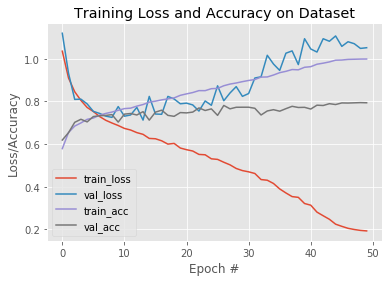

In [24]:
# Plot the training loss and accuracy.
import matplotlib.pyplot as plt
 
# Plot
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### Make predicitions on the original test data i.e. `test_x`  and prepare the submission file

In [25]:
pred = model.predict_on_batch(test_x)

In [28]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(pred, axis=1)

In [32]:
predIdxs

array([0, 2, 0, ..., 0, 0, 2])

In [35]:
pred_transform = lb.inverse_transform(predIdxs) # Transform labels back to original encoding.
test_csv['Class'] = pred_transform
test_csv.to_csv('submission_sayak_resnet.csv', index=False)

In [38]:
!head -5 submission_sayak_resnet.csv

ID,Class
25321.jpg,MIDDLE
989.jpg,YOUNG
19277.jpg,MIDDLE
13093.jpg,YOUNG
